In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!unzip /content/drive/MyDrive/whichfaceisreal.zip -d /content/

Archive:  /content/drive/MyDrive/whichfaceisreal.zip
replace /content/__MACOSX/._whichfaceisreal? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [10]:
import os
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torchvision
from tqdm import tqdm
from torchvision import transforms
import numpy as np


class ResNet18(nn.Module):
    def __init__(self, pretrained=False, probing=False):
        super(ResNet18, self).__init__()
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            self.transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
            self.resnet18 = resnet18(weights=weights)
        else:
            self.transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
            self.resnet18 = resnet18()


        in_features_dim = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Identity()
        if probing:
            for name, param in self.resnet18.named_parameters():
                    param.requires_grad = False
        self.logistic_regression = nn.Linear(in_features_dim, 1)

    def forward(self, x):
        features = self.resnet18(x)
        logit = self.logistic_regression(features)
        return logit

def get_loaders(path, transform, batch_size):
    """
    Get the data loaders for the train, validation and test sets.
    :param path: The path to the 'whichfaceisreal' directory.
    :param transform: The transform to apply to the images.
    :param batch_size: The batch size.
    :return: The train, validation and test data loaders.
    """
    train_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'train'), transform=transform)
    val_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'val'), transform=transform)
    test_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'test'), transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

def compute_accuracy(model, data_loader, device):
    """
    Compute the accuracy of the model on the data in data_loader
    :param model: The model to evaluate.
    :param data_loader: The data loader.
    :param device: The device to run the evaluation on.
    :return: The accuracy of the model on the data in data_loader
    """
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(imgs)
            predictions = (outputs > 0).float()

            correct += (predictions == labels).sum().item()
            total += labels.size(0)
    return correct / total

def run_training_epoch(model, criterion, optimizer, train_loader, device):
    """
    Run a single training epoch
    :param model: The model to train
    :param criterion: The loss function
    :param optimizer: The optimizer
    :param train_loader: The data loader
    :param device: The device to run the training on
    :return: The average loss for the epoch.
    """
    model.train()
    running_loss = 0.0
    for (imgs, labels) in tqdm(train_loader, total=len(train_loader)):
        model.train()
        # Move data to GPU
        imgs = imgs.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(train_loader)



# Set the random seed for reproducibility
torch.manual_seed(0)



batch_size = 32
num_of_epochs = 1
learning_rate = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
path = '/content/whichfaceisreal'

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
baseline_results = {}
for lr in LRS:
    print(f"\n Training with Learning Rate: {lr}")
    ### UNCOMMENT THE FOLLOWING LINES TO TRAIN THE MODEL ###
    # From Scratch
    # model = ResNet18(pretrained=False, probing=False).to(device)
    # Linear probing
    # model = ResNet18(pretrained=True, probing=True).to(device)



    # Fine-tuning
    model = ResNet18(pretrained=True, probing=False).to(device)
    transform = model.transform
    train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)
    ### Define the loss function and the optimizer
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    # Train the model
    for epoch in range(num_of_epochs):
        # Run a training epoch
        loss = run_training_epoch(model, criterion, optimizer, train_loader, device)
        # Compute the accuracy
        train_acc = compute_accuracy(model, train_loader, device)
        # Compute the validation accuracy
        val_acc = compute_accuracy(model, val_loader, device)
        test_acc = compute_accuracy(model, test_loader, device)
        print(f"LR {lr} | Loss: {loss:.4f} | Val Acc: {val_acc:.4f} | Test Acc: {test_acc:.4f}")
        print(f'Epoch {epoch + 1}/{num_of_epochs}, Loss: {loss:.4f}, Val accuracy: {val_acc:.4f}')
        baseline_results[lr] = {
                    "val_acc": val_acc,
                    "test_acc": test_acc
            }

print("\n--- Summary for this Baseline ---")
for lr, accs in baseline_results.items():
    print(f"LR: {lr} -> Test Accuracy: {accs['test_acc']:.4f}")




 Training with Learning Rate: 0.1


100%|██████████| 44/44 [00:44<00:00,  1.02s/it]


LR 0.1 | Loss: 1.8089 | Val Acc: 0.5200 | Test Acc: 0.5225
Epoch 1/1, Loss: 1.8089, Val accuracy: 0.5200

 Training with Learning Rate: 0.01


100%|██████████| 44/44 [00:44<00:00,  1.01s/it]


LR 0.01 | Loss: 0.9419 | Val Acc: 0.4700 | Test Acc: 0.5175
Epoch 1/1, Loss: 0.9419, Val accuracy: 0.4700

 Training with Learning Rate: 0.001


100%|██████████| 44/44 [00:44<00:00,  1.02s/it]


LR 0.001 | Loss: 0.6223 | Val Acc: 0.7300 | Test Acc: 0.7725
Epoch 1/1, Loss: 0.6223, Val accuracy: 0.7300

 Training with Learning Rate: 0.0001


100%|██████████| 44/44 [00:45<00:00,  1.02s/it]


LR 0.0001 | Loss: 0.4606 | Val Acc: 0.8550 | Test Acc: 0.8500
Epoch 1/1, Loss: 0.4606, Val accuracy: 0.8550

 Training with Learning Rate: 1e-05


100%|██████████| 44/44 [00:44<00:00,  1.02s/it]


LR 1e-05 | Loss: 0.6371 | Val Acc: 0.6600 | Test Acc: 0.7250
Epoch 1/1, Loss: 0.6371, Val accuracy: 0.6600

--- Summary for this Baseline ---
LR: 0.1 -> Test Accuracy: 0.5225
LR: 0.01 -> Test Accuracy: 0.5175
LR: 0.001 -> Test Accuracy: 0.7725
LR: 0.0001 -> Test Accuracy: 0.8500
LR: 1e-05 -> Test Accuracy: 0.7250


In [12]:
import os
import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights
import torch
import torchvision
from tqdm import tqdm
from torchvision import transforms
import numpy as np
from xgboost import XGBClassifier

def get_loaders(path, transform, batch_size):
    """
    Get the data loaders for the train, validation and test sets.
    :param path: The path to the 'whichfaceisreal' directory.
    :param transform: The transform to apply to the images.
    :param batch_size: The batch size.
    :return: The train, validation and test data loaders.
    """
    train_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'train'), transform=transform)
    val_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'val'), transform=transform)
    test_set = torchvision.datasets.ImageFolder(root=os.path.join(path, 'test'), transform=transform)

    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

# Set the random seed for reproducibility
np.random.seed(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.CenterCrop(64), transforms.ToTensor()])
batch_size = 32
path = '/content/whichfaceisreal'
train_loader, val_loader, test_loader = get_loaders(path, transform, batch_size)


# DATA LOADING
### DO NOT CHANGE THE CODE BELOW THIS LINE ###
train_data = []
train_labels = []
test_data = []
test_labels = []
with torch.no_grad():
    for (imgs, labels) in tqdm(train_loader, total=len(train_loader), desc='Train'):
        train_data.append(imgs)
        train_labels.append(labels)
    train_data = torch.cat(train_data, 0).cpu().numpy().reshape(len(train_loader.dataset), -1)
    train_labels = torch.cat(train_labels, 0).cpu().numpy()
    for (imgs, labels) in tqdm(test_loader, total=len(test_loader), desc='Test'):
        test_data.append(imgs)
        test_labels.append(labels)
    test_data = torch.cat(test_data, 0).cpu().numpy().reshape(len(test_loader.dataset), -1)
    test_labels = torch.cat(test_labels, 0).cpu().numpy()
### DO NOT CHANGE THE CODE ABOVE THIS LINE ###


xgb_model = XGBClassifier()

print("Training XGBoost model...")
xgb_model.fit(train_data, train_labels)

xgb_acc = xgb_model.score(test_data, test_labels)
print(f"\n--- XGBoost Baseline Results ---")
print(f"Test Accuracy: {xgb_acc:.4f}")



Test: 100%|██████████| 13/13 [00:12<00:00,  1.05it/s]


Training XGBoost model...

--- XGBoost Baseline Results ---
Test Accuracy: 0.7350


In [15]:
from sklearn.linear_model import LogisticRegression
import numpy as np

model = ResNet18(pretrained=True, probing=True).to(device)
model.eval()


def get_features_and_labels(loader):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for imgs, labels in tqdm(loader, desc="Mr. Lee is extracting cats..."):
            imgs = imgs.to(device)
            features = model.resnet18(imgs)
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.numpy())

    return np.concatenate(all_features), np.concatenate(all_labels)

print("Extracting features from images...")
X_train, y_train = get_features_and_labels(train_loader)
X_test, y_test = get_features_and_labels(test_loader)

Extracting features from images...


Mr. Lee is extracting cats...: 100%|██████████| 13/13 [00:12<00:00,  1.02it/s]


In [19]:
sklearn_model = LogisticRegression(max_iter=1024)

print("Training Sklearn Log Regression")
sklearn_model.fit(X_train, y_train)
bonus_acc = sklearn_model.score(X_test, y_test)
print(f"Test Accuracy for Bonus: {bonus_acc: .4f}")

Training Sklearn Log Regression
Test Accuracy for Bonus:  0.6900


In [20]:
# TRAIN THE "BEST" MODEL (Fine-tuning at LR 0.0001)
print("Training Best Model (Fine-tuning)...")
fine_tuning_model = ResNet18(pretrained=True, probing=False).to(device)
ft_transform = fine_tuning_model.transform
ft_train_loader, _, ft_test_loader = get_loaders(path, ft_transform, batch_size)

optimizer_ft = torch.optim.Adam(fine_tuning_model.parameters(), lr=1e-4)
criterion = torch.nn.BCEWithLogitsLoss()
run_training_epoch(fine_tuning_model, criterion, optimizer_ft, ft_train_loader, device)

# TRAIN THE "WORST" MODEL (From Scratch at LR 0.1)
print("\nTraining Worst Model (Scratch)...")
scratch_model = ResNet18(pretrained=False, probing=False).to(device)
sc_transform = scratch_model.transform
sc_train_loader, _, sc_test_loader = get_loaders(path, sc_transform, batch_size)

optimizer_sc = torch.optim.Adam(scratch_model.parameters(), lr=1e-1)
run_training_epoch(scratch_model, criterion, optimizer_sc, sc_train_loader, device)

Training Best Model (Fine-tuning)...


100%|██████████| 44/44 [00:44<00:00,  1.02s/it]



Training Worst Model (Scratch)...


100%|██████████| 44/44 [00:44<00:00,  1.00s/it]


1.1828007413582369

Saved comparison to comparison_images.png


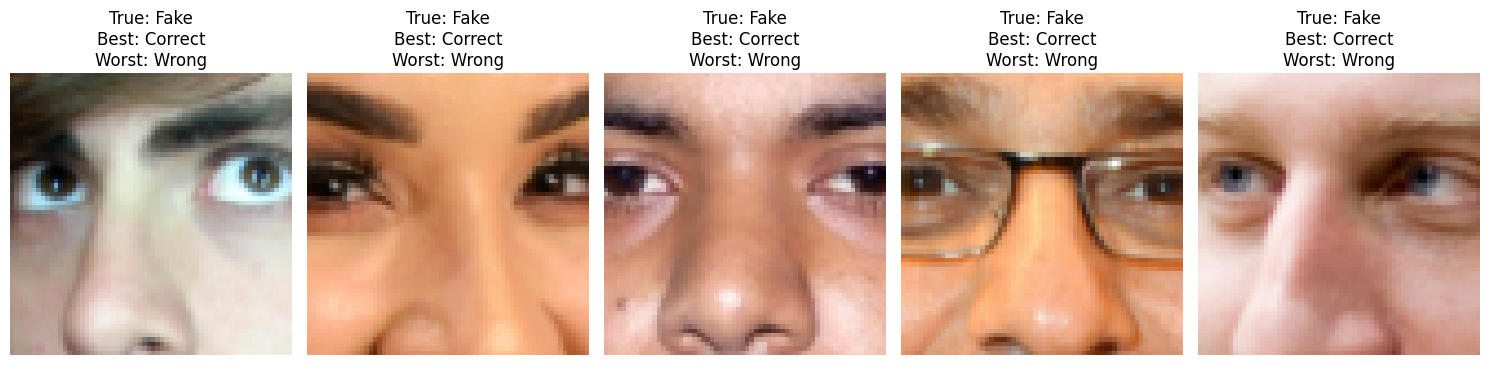

In [21]:
import matplotlib.pyplot as plt
import torch

def get_comparison_plot(best_model, worst_model, test_loader, device,
                        save_path='comparison_images.png'):
    best_model.eval()
    worst_model.eval()
    samples = []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            # logit > 0 means real
            best_preds = (best_model(imgs) > 0).float().view(-1)
            worst_preds = (worst_model(imgs) > 0).float().view(-1)

            for i in range(len(labels)):
                # Criterion: Best is Correct AND Worst is Incorrect
                if best_preds[i] == labels[i] and worst_preds[i] != labels[i]:
                    img = imgs[i].cpu().permute(1, 2, 0).numpy()
                    img = (img - img.min()) / (img.max() - img.min())
                    label_text = "Real" if labels[i] == 1 else "Fake"
                    samples.append((img, label_text))

                if len(samples) >= 5:
                    break
            if len(samples) >= 5: break

    # Plotting
    plt.figure(figsize=(15, 5))
    for i, (img, lbl) in enumerate(samples):
        plt.subplot(1, 5, i+1)
        plt.imshow(img)
        plt.title(f"True: {lbl}\nBest: Correct\nWorst: Wrong")
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path)
    print(f"Saved comparison to {save_path}")

# Run the function (ensure your models are loaded/defined)
get_comparison_plot(fine_tuning_model, scratch_model, test_loader, device)